# Loading the data as a time series

In [1]:
import numpy as np
# import mne
from scipy.io import loadmat
from scipy.signal import decimate
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from eeg_utils import mat_to_dataframe, downsample_eeg_dataframe
%matplotlib inline

In [2]:
mat = mat_to_dataframe("sub-0cGdk9_HoldL_MedOff_run1_LFP_Hilbert/sub_AbzsOg_HoldL_MedOff_merged_LFP_Hilbert.mat")

--- Processing file: sub_AbzsOg_HoldL_MedOff_merged_LFP_Hilbert.mat ---
Found data matrix. Key: 'selected_channels_signal', Shape: (2, 2055000)
Found labels. Key: 'target_labels'
Labels extracted: ['LFP-right-34', 'LFP-left-56']


--- DataFrame Created Successfully ---
          LFP-right-34  LFP-left-56
Time (s)                           
0.0000        1.040826     0.850662
0.0005        0.038125     1.269358
0.0010        1.173294     0.220776
0.0015        1.394147     2.182392
0.0020        0.266420     3.403933

Successfully extracted left LFP channel: 'LFP-left-56'
Successfully extracted right LFP channel: 'LFP-right-34'


In [3]:
mat

(           LFP-right-34  LFP-left-56
 Time (s)                            
 0.0000         1.040826     0.850662
 0.0005         0.038125     1.269358
 0.0010         1.173294     0.220776
 0.0015         1.394147     2.182392
 0.0020         0.266420     3.403933
 ...                 ...          ...
 1027.4975      2.547363    -7.389524
 1027.4980      4.159000    -7.272926
 1027.4985      1.670323    -9.315841
 1027.4990     -0.369962    -8.971549
 1027.4995      0.041257    -5.683990
 
 [2055000 rows x 2 columns],
 Time (s)
 0.0000       0.850662
 0.0005       1.269358
 0.0010       0.220776
 0.0015       2.182392
 0.0020       3.403933
                ...   
 1027.4975   -7.389524
 1027.4980   -7.272926
 1027.4985   -9.315841
 1027.4990   -8.971549
 1027.4995   -5.683990
 Name: LFP-left-56, Length: 2055000, dtype: float64,
 Time (s)
 0.0000       1.040826
 0.0005       0.038125
 0.0010       1.173294
 0.0015       1.394147
 0.0020       0.266420
                ...   
 1027.4975 

Time (s)
0.0000       1.040826
0.0005       0.038125
0.0010       1.173294
0.0015       1.394147
0.0020       0.266420
               ...   
1027.4975    2.547363
1027.4980    4.159000
1027.4985    1.670323
1027.4990   -0.369962
1027.4995    0.041257
Name: LFP-right-34, Length: 2055000, dtype: float64
Time (s)
0.0000       0.850662
0.0005       1.269358
0.0010       0.220776
0.0015       2.182392
0.0020       3.403933
               ...   
1027.4975   -7.389524
1027.4980   -7.272926
1027.4985   -9.315841
1027.4990   -8.971549
1027.4995   -5.683990
Name: LFP-left-56, Length: 2055000, dtype: float64

Plotting first 5000 samples...


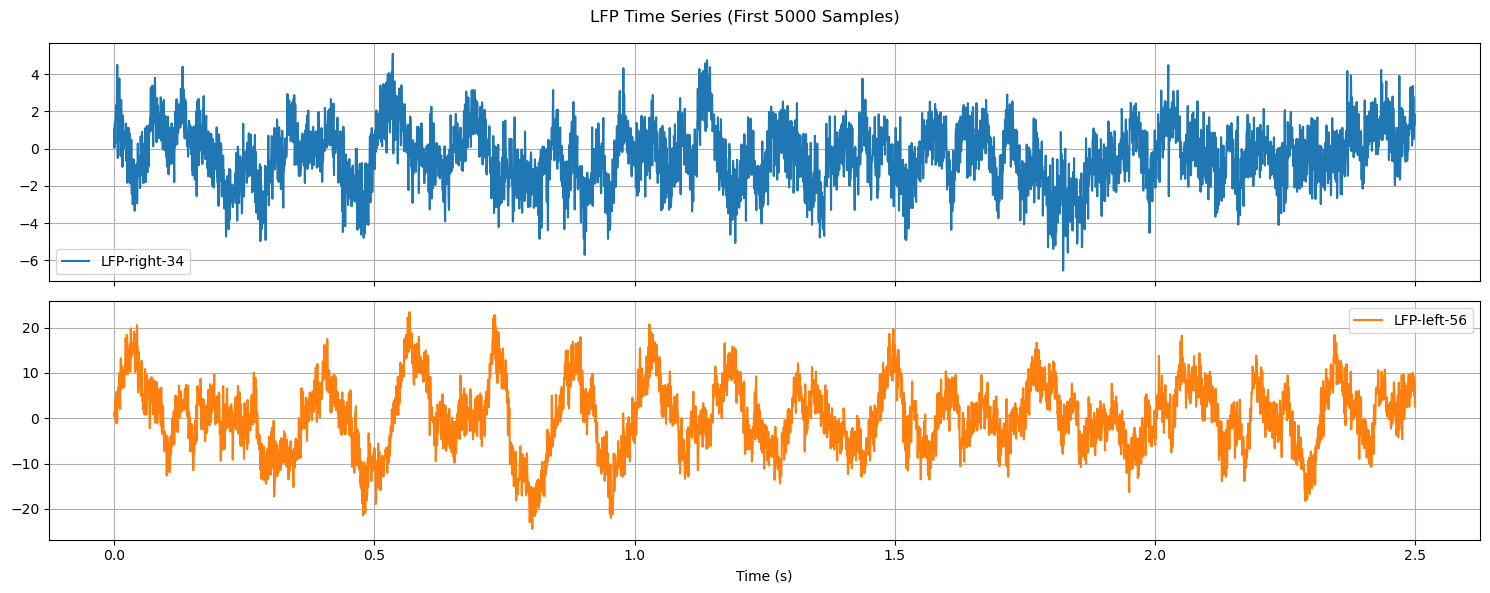

In [22]:
# You can now easily access each channel
# right_lfp = df['LFP-right-34']
# left_lfp = df['LFP-left-56']
right_lfp = df['LFP-right-34']
left_lfp = df['LFP-left-56']
print(right_lfp)
print(left_lfp)
if 'df' in locals():
    print("\nPlotting first 5000 samples...")
    plot_slice = 5000
    
    df.iloc[:plot_slice].plot(
        subplots=True,   # Plot each channel separately
        layout=(2, 1),   # Arrange in 2 rows, 1 column
        grid=True,
        title="LFP Time Series (First 5000 Samples)",
        figsize=(15, 6)  # Width, Height in inches
    )
    plt.xlabel(df.index.name)
    plt.tight_layout()
    plt.show()

In [23]:
type(df)
print(df.head())
print(df.tail())

          LFP-right-34  LFP-left-56
Time (s)                           
0.0000        1.040826     0.850662
0.0005        0.038125     1.269358
0.0010        1.173294     0.220776
0.0015        1.394147     2.182392
0.0020        0.266420     3.403933
           LFP-right-34  LFP-left-56
Time (s)                            
1027.4975      2.547363    -7.389524
1027.4980      4.159000    -7.272926
1027.4985      1.670323    -9.315841
1027.4990     -0.369962    -8.971549
1027.4995      0.041257    -5.683990


In [25]:
df_dwn = downsample_eeg_dataframe(df=df,
                                  original_fs=2000,
                                  target_fs=50,
                                  plot=False)

Downsampling by a factor of 40...
--- Downsampled DataFrame ---
          LFP-right-34  LFP-left-56
Time (s)                           
0.00          1.049429    -0.534954
0.02          0.807874    12.923769
0.04         -1.615404    12.817129
0.06          0.045239     6.646186
0.08          1.846260     3.933646
--- New DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 51375 entries, 0.0 to 1027.48
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LFP-right-34  51375 non-null  float64
 1   LFP-left-56   51375 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB



Plotting first 5000 samples...


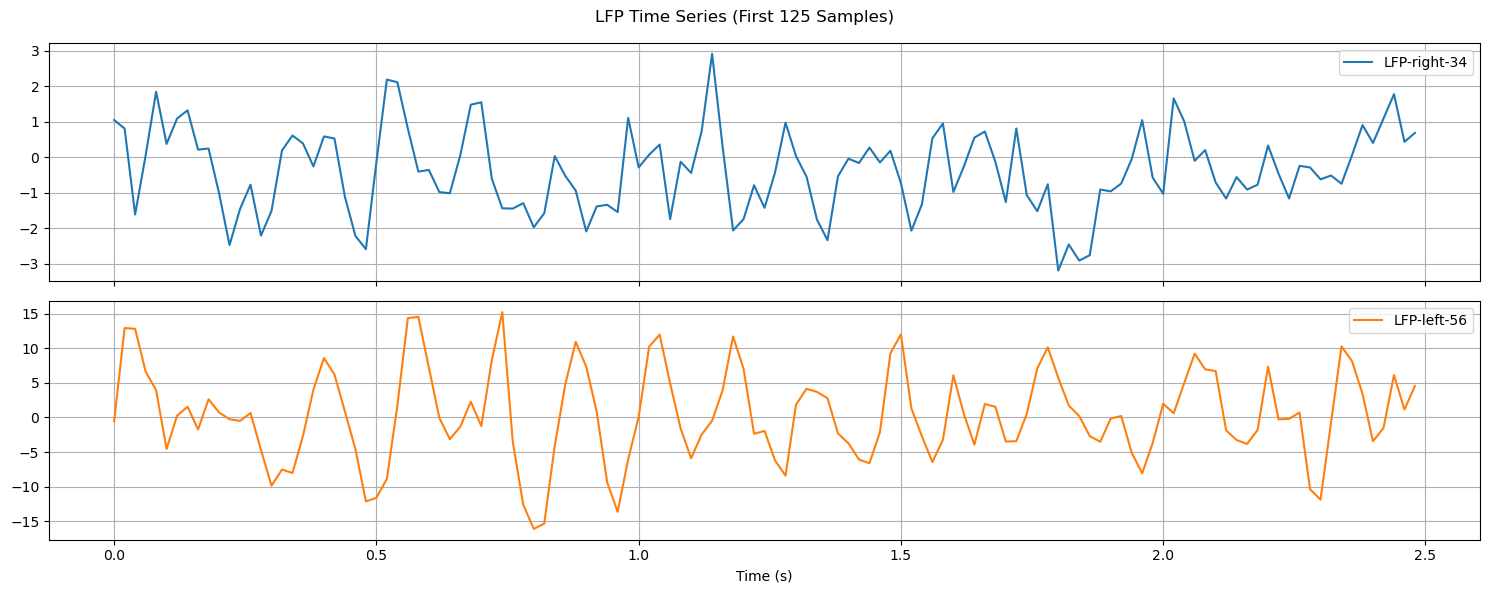

In [27]:
print("\nPlotting first 5000 samples...")
plot_slice = 125

df_dwn.iloc[:plot_slice].plot(
    subplots=True,   # Plot each channel separately
    layout=(2, 1),   # Arrange in 2 rows, 1 column
    grid=True,
    title=f"LFP Time Series (First {plot_slice} Samples)",
    figsize=(15, 6)  # Width, Height in inches
)
plt.xlabel(df_dwn.index.name)
plt.tight_layout()
plt.show()

In [39]:
num_of_samples_to_keep = 125

left = df_dwn['LFP-left-56'].iloc[:num_of_samples_to_keep]
right = df_dwn['LFP-right-34'].iloc[:num_of_samples_to_keep]

# Doing the TDA magic

In [80]:
from gtda.time_series import SingleTakensEmbedding
from gtda.time_series import TakensEmbedding
import itertools

# --- Plotting Libraries ---
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.diagrams import PersistenceEntropy

from eeg_utils import fit_embedder, filter_persistence_diagram, extract_features

# --- Set Plotting Themes to Light Mode ---
pio.templates.default = "plotly_white" # For plotly and giotto-tda plots
plt.style.use('default') # For matplotlib plots


In [79]:
import eeg_utils
importlib.reload(eeg_utils)

<module 'eeg_utils' from '/home/ilgazc/Data/Parkinson_medOn_medOff/eeg_utils.py'>

## The current situation of the data
- Down sampled to 50 Hz
- Cut to first 2.5 seconds
- Variables are left and right

In [43]:
max_embedding_dim = 30
max_time_delay = 30
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dim,
    stride=stride,
    n_jobs=-1
)

In [40]:
print(len(left))

125


In [44]:
left_embedded = fit_embedder(embedder, left)
right_embedded = fit_embedder(embedder, right)

Shape of embedded time series: (121, 5)
Optimal embedding dimension is 5 and time delay is 1
Shape of embedded time series: (113, 5)
Optimal embedding dimension is 5 and time delay is 3


In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
left_embedded_pca = pca.fit_transform(left_embedded)
plot_point_cloud(left_embedded_pca)

In [46]:
right_embedded_pca = pca.fit_transform(right_embedded)
plot_point_cloud(right_embedded_pca)

In [47]:
left_embedded = left_embedded[None, :, :]
right_embedded = right_embedded[None, :, :]

In [85]:
homology_dims = [0, 1, 2, 3]

In [61]:
# Define a threshold for the lifespan of TDA features

lifespan_threshold = 0.2

In [86]:
left_persistence = VietorisRipsPersistence(homology_dimensions=homology_dims, n_jobs=-1)
left_diagram = left_persistence.fit_transform(left_embedded)

left_diagram_flt = filter_persistence_diagram(left_diagram, lifespan_threshold=lifespan_threshold)
left_persistence.plot(left_diagram_flt)

Original number of topological features: 179
Number of features after filtering: 165


In [84]:
right_persistence = VietorisRipsPersistence(homology_dimensions=homology_dims, n_jobs=-1)
right_diagram = right_persistence.fit_transform(right_embedded)

right_diagram_flt = filter_persistence_diagram(right_diagram, lifespan_threshold=lifespan_threshold)
right_persistence.plot(right_diagram)

Original number of topological features: 198
Number of features after filtering: 134


# Feature Extraction

## Persistence Entropy

In [65]:
PE = PersistenceEntropy()
left_pe_features = PE.fit_transform(left_diagram_flt)
print(left_pe_features)

[[6.84294692 5.0749222  2.30627871]]


In [66]:
PE = PersistenceEntropy()
right_pe_features = PE.fit_transform(right_diagram_flt)
print(right_pe_features)

[[6.73257253 4.31106383 0.        ]]


## Other Small Features

In [81]:
left_sm_features = extract_features(left_diagram_flt, homology_dimensions=homology_dims, verbose=True)
right_sm_features = extract_features(right_diagram_flt, homology_dimensions=homology_dims, verbose=True)

--- Extracted Features ---
	h0_feature_count: 120.0000
	h0_avg_lifespan : 5.7405
	h0_max_lifespan : 13.5616
	h0_std_lifespan : 1.7865
	h0_avg_birth    : 0.0000
	h0_avg_death    : 5.7405
	h1_feature_count: 40.0000
	h1_avg_lifespan : 0.8927
	h1_max_lifespan : 2.5944
	h1_std_lifespan : 0.5403
	h1_avg_birth    : 7.4500
	h1_avg_death    : 8.3427
	h2_feature_count: 5.0000
	h2_avg_lifespan : 0.5081
	h2_max_lifespan : 0.6100
	h2_std_lifespan : 0.0746
	h2_avg_birth    : 8.9637
	h2_avg_death    : 9.4718
--- Extracted Features ---
	h0_feature_count: 112.0000
	h0_avg_lifespan : 1.3484
	h0_max_lifespan : 2.3938
	h0_std_lifespan : 0.4279
	h0_avg_birth    : 0.0000
	h0_avg_death    : 1.3484
	h1_feature_count: 21.0000
	h1_avg_lifespan : 0.3591
	h1_max_lifespan : 0.6031
	h1_std_lifespan : 0.1219
	h1_avg_birth    : 1.6821
	h1_avg_death    : 2.0412
	h2_feature_count: 1.0000
	h2_avg_lifespan : 0.2463
	h2_max_lifespan : 0.2463
	h2_std_lifespan : 0.0000
	h2_avg_birth    : 2.5627
	h2_avg_death    : 2.8089
